In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt

In [248]:
# The directory which stores all the .dat files
directory = 'C:\\Program Files (x86)\\USGS\\Phreeqc Interactive 3.7.3-15968\\database\\'

def logkdata(filename):
    '''
    Returns a Pandas database when given a .dat or .txt file. 

            Input Parameters:
                    filename (str): The name of the file including the extension

            Returns:
                    df (Pandas dataframe): A dataframe containing the reactions under a species column 
                                            and log k values under a Log_k_values column
    '''

    p2 = filename
    path = directory+p2

    # Read every line within the file, reads line as a string into a list called output
    with open(path,'r',encoding='utf-8') as f:
        output = f.readlines()

    num_lines = len(output)

    # The chemical needed is usually not indented, with all the relevant information being indented underneath
    # Because of this, we will try to order the information by checking for indentation

    species = []
    log_k = []

    # Pad the end of the text file with two new lines to prevent loop out of range when searching for logk
    output.append('\n')
    output.append('\n')

    # Create a list of all the excess values that will be read that need to be removed
    noise_list = [" ", "\n", "#", "log_k", "primarymasterspecies", ";", "\t", "=pKa1,int", "=pKa2,int", "=-pKa2,int"]

    # Create a function that removes the excess from the string that is read
    def cleaner(string, noise = noise_list):
        '''
        Removes unwanted parts of a string based on a provided list of what needs to be taken out 

            Input Parameters:
                    string (str): The input string from which things need to be removed
                    noise (str list): A str list of all the variables to be parsed for

            Returns:
                    string (str): The input string with all elements from the noise list removed
        '''
        for i in noise:
            string = string.replace(i, "")
        return string

    # Loop over the information for each line
    for i in range(num_lines):
        # If there is an equals sign there is a chance it is one of the species we need to add with its log k value
        # Check if the line has an equals sign
        if output[i].find('=') != -1:
            # Search for the lines with log_k data
            # Find function returns the starting index of the substring
            # If the substring does not exist within the line, it returns -1
            # First check if the same line has the log_k value
            if output[i].find('log_k') != -1:
                # Seperate the string by where log k is written
                # Before is everything before the input partition, partition is 'log_k' and after is everything after
                before, partition, after = output[i].partition('log_k')
                # Use the cleaner function to get just the specie and log k value before adding to the list
                after = cleaner(after)
                before = cleaner(before)
                log_k.append(after)
                species.append(before)
            # Carry out another similar check for the log k value on the next line
            elif output[i+1].find('log_k') != -1:
                # Partition and clean the next line
                before, partition, after = output[i+1].partition('log_k')
                after = cleaner(after)
                b = cleaner(output[i])
                log_k.append(after)
                species.append(b)
            # Carry out one last check 2 lines after the species to find log_k value
            elif output[i+2].find('log_k') != -1:
                # Partition and clean the line again
                before, partition, after = output[i+2].partition('log_k')
                after = cleaner(after)
                b = cleaner(output[i])
                log_k.append(after)
                species.append(b)
            else:
                continue
    # Species are now in one list and log_k are in the other
    # Join them together into one pandas dataframe

    df = pd.DataFrame(list(zip(species, log_k)), columns =['Species', 'Log_k_values'])
    # Convert all the log k values to float. Convert to NaN if they can't be converted
    df.Log_k_values = df.Log_k_values.apply(pd.to_numeric, errors='coerce')
    # Drop all rows with NaN
    df = df.dropna() 
    return df

In [249]:
logkdata('Tipping_Hurley.dat')

,Species,Log_k_values
0,H+=H+,0.00
1,e-=e-,0.00
2,H2O=H2O,0.00
3,Ag+=Ag+,0.00
4,Al+3=Al+3,0.00
...,...,...
928,H_cdH2+Pb+2=H_cdPb+2H+,-1.62
929,H_cfH2+Pb+2=H_cfPb+2H+,-3.85
930,H_chH2+Pb+2=H_chPb+2H+,-3.85
931,H_deH2+Pb+2=H_dePb+2H+,-3.85


In [250]:
logkdata('minteq.dat')

,Species,Log_k_values
0,e-=e-,0.00
1,H+=H+,0.00
2,H2O=H2O,0.00
3,2H2O=O2+4H++4e-,-86.08
4,2H++2e-=H2,-3.15
...,...,...
1604,Hfo_wOH+H3AsO4=Hfo_wAsO4-2+H2O+2H+,-4.70
1605,Hfo_sOH+H3AsO4=Hfo_sOHAsO4-3+3H+,-10.15
1606,Hfo_wOH+H3AsO4=Hfo_wOHAsO4-3+3H+,-10.15
1607,Hfo_sOH+H3BO3=Hfo_sH2BO3+H2O,0.62


In [71]:
# Create a function to check whether a value is in a specific dataset

# Empty list to store all file names
filenames = []

# iterate over files in the database directory
for filename in os.listdir(directory):
    var = os.path.join(directory, filename)
    # Add the variable filename to the list
    if os.path.isfile(var):
        filenames.append(filename)

def checker(species):
    '''
    A function to check all values in the species column for if they match the input
    Returns a database with only those species rows which match the search variable. 
    Search function takes into account capitalisation (e.g. 2H2O vs 2h2o)

        Input Parameters:
                species (str): The string variable to search the species column for

        Returns:
                final_df (Pandas dataframe): A dataframe containing the reactions searched forunder a 
                                            species column and log k values under a Log_k_values column 
    '''

    # Create the final dataframe which will include all the checked values
    final_df = pd.DataFrame()
    
    # iterate over filenames
    for i in filenames:
        # Load the database into this variable
        DataBase = logkdata(i)
        # Create a smaller databse consisting of lines only containing the input species
        # regex  = False as bracketed elements are not a substring of the search
        # Create a copied database with: Database[condition]
        DB_check = DataBase[DataBase.Species.str.contains(species, regex = False) == True].copy()
        # Add the filename as an extra last column of data
        DB_check['File'] = i
        # Add the filtered dataframe to the final one
        final_df = pd.concat([final_df, DB_check])
        
    #concat function takes the index from the previous database and doesnt change it - reset this
    final_df = final_df.reset_index(drop=True)
    return final_df

In [254]:
checker('Cu2(OH)2')

,Species,Log_k_values,File
0,2Cu+2+2H2O=Cu2(OH)2+2+2H+,-10.359,Amm.dat
1,2Cu+2+2H2O=Cu2(OH)2+2+2H+,-10.359,minteq.dat
2,Cu2(OH)2CO3+2H+=2Cu+2+2H2O+CO3-2,-5.180,minteq.dat
3,2Cu+2+2H2O=Cu2(OH)2+2+2H+,-10.594,minteq.v4.dat
4,Cu2(OH)2CO3+2H+=2Cu+2+2H2O+CO3-2,-5.306,minteq.v4.dat
5,2Cu+2+2H2O=Cu2(OH)2+2+2H+,-10.359,phreeqc.dat
6,2Cu+2+2H2O=Cu2(OH)2+2+2H+,-10.359,Tipping_Hurley.dat
7,Cu2(OH)2CO3+3H+=2Cu+2+2H2O+HCO3-,5.150,Tipping_Hurley.dat
8,2Cu+2+2H2O=Cu2(OH)2+2+2H+,-10.359,wateq4f.dat
9,Cu2(OH)2CO3+3H+=2Cu+2+2H2O+HCO3-,5.150,wateq4f.dat


In [243]:
# Given the previous search, the user would want to select a log k value themselves from the database
# Allow the user to input the relevant values and output the required graph
# After choosing a reaction: number of moles and charge of the ion need to be taken to calculate the stability constant

example = '2Zn+2 + 2Cit-3 + 2H2O = Zn2(OH)2Cit2-4 + 2H+'

# ionic strength values to calculate stability constant for
ionic_str = [0, 0.05, 0.15, 0.3, 0.5, 1]

# Function to check whether a value can be an integer or not
# Input must be a string
def int_check(x):
    """
    A function to check whether a string can be converted to an integer
    
        Input Parameters:
                x (str): The value to check
        
        Returns:
                Boolean
    """
    try:
        int(x)
        return True
    except ValueError:
        return False

def stability_graph(str_var, k_int):
    '''
    This function takes in an input reaction as a string and an intrinsic k value as a float.
    It will use the Davies equation to predict and plot the stability graph for any given reaction.

        Input Parameters:
                str_var (str): The chemical reaction to be calculated for
                k_int (float): The intrinsic k value for the reaction

        Returns:
                A plot of the stability graph for the reaction
    '''
    # First get rid of all spaces within the equation if any
    str_var = str_var.replace(" ", "")
    
    # Split the equation into before and after the equal sign
    # Calculations for each side will be done separately
    before, partition, after = str_var.partition('=')
    # Split for each of the reactants in the equations by the + sign
    splitone = re.split(r"[+]", before)
    splittwo = re.split(r"[+]", after)
    
    # This splitting will also split on a + charge at the end of a reactant
    # it will instead add '' or the number as an extra variable to the list
    # Add back the correct charge if this is the case and remove empty variable from the list
    for i in range(len(splitone)):
        if splitone[i] == '':
            splitone[i-1]+='+'
        if int_check(splitone[i]) == True:
            splitone[i-1]+='+' + splitone[i]
            # Replace the int with '' so that it is removed from the list later
            splitone[i] = ''
    
    for i in range(len(splittwo)):
        if splittwo[i] == '':
            splittwo[i-1]+='+'
        if int_check(splittwo[i]) == True:
            splittwo[i-1]+='+' + splittwo[i]
            # Replace the int with '' so that it is removed from the list later
            splittwo[i] = ''
    
    # Remove the empty '' variables from within the list if they exist
    while '' in splitone:
        splitone.remove('')
    
    while '' in splittwo:
        splittwo.remove('')
    
    # Empty list to store the stability constant at each salinity level for the reaction
    stab_const = []
    
    # Each calculation is done for each salinity level
    for j in range(len(ionic_str)):
        # Following equation spreadsheet from George's paper calculations
        # Variable names follow the column in his spreadsheet
        E = (ionic_str[j]**0.5)/(1+(ionic_str[j]**0.5))
        F = -0.3 * ionic_str[j]
        
        # Empty lists to store the stability constants for the LHS and RHS of the reaction
        LHS = []
        RHS = []
        
        # For each variable in the lists, calculate the activity coefficient at the given salinity level
        # First get all variables that are needed for each compound in the equations
        for i in range(len(splitone)):
            # Find the number of moles of the compound
            # If it begins with a number, find the whole number, otherwise it is 1 mole
            if splitone[i][0].isdigit() == True:
                moles = re.search(r'(\d+)',splitone[i]).group()
                moles = int(moles)
            else:
                moles = 1 
            # Find the charge as a symbol followed by an optional number
            charge = re.findall('[+|-][0-9]?', splitone[i])
            # Convert the charge into an integer value
            if charge == []:
                charge = 0
            elif charge[0] == '+':
                charge = 1
            elif charge[0] == '-':
                charge = -1
            else:
                charge = int(charge[0])
                
            # Following the equation from George's paper to find the stability constant
            # -0.51 is the dialectric constant for the solvent, should this change? be user input??
            D = -0.51*charge**2
            G = D*(E+F)*moles
            LHS.append(G)
            
        for i in range(len(splittwo)):
            # Find the number of moles of the compound
            # If it begins with a number, find the whole number, otherwise it is 1 mole
            if splittwo[i][0].isdigit() == True:
                moles = re.search(r'(\d+)',splittwo[i]).group()
                moles = int(moles)
            else:
                moles = 1 
            # Find the charge as a symbol followed by an optional number
            charge = re.findall('[+|-][0-9]?', splittwo[i])
            # Convert the charge into an integer value
            if charge == []:
                charge = 0
            elif charge[0] == '+':
                charge = 1
            elif charge[0] == '-':
                charge = -1
            else:
                charge = int(charge[0])
                
            # Following the equation from George's paper to find the stability constant
            # -0.51 is the dialectric constant for the solvent, should this change? be user input??
            D = -0.51*charge**2
            G = D*(E+F)*moles
            RHS.append(G)
        
        # Sum the completed RHS and LHS sides and subtract appropriately
        logyr = sum(RHS) - sum(LHS)
        sc = k_int - logyr
        stab_const.append(sc)
    
    # Create polynomial of order 2
    poly = np.polyfit(ionic_str, stab_const, 2)
    # Create a range of values between which a line of best fit will be made
    x = np.linspace(ionic_str[0], ionic_str[-1], num = 100)
    polynomial = np.polyval(poly, x)
    
    # Using the values, plot the graph against salinity with polynomial line of best fit
    plt.scatter(ionic_str, stab_const)
    plt.title('%s' %(str_var))
    plt.xlabel('Ionic Strength (mol/dm$^{3}$)')
    plt.ylabel('Stability Constant (log β)')
    plt.plot(x, polynomial, '-')  
    plt.show()

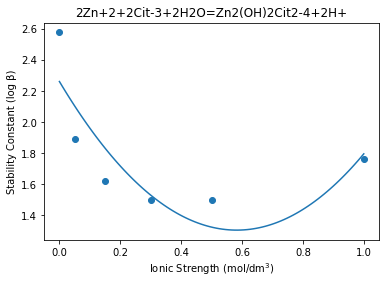

In [256]:
# example = '12Zn+2 + 2Cit-3 + 2H2O = Zn2(OH)2Cit2-4 + 2H+'
stability_graph(example, 2.576)

In [245]:
# Input of the function should be a compound that is being searched for
# This function plots all of the equations within the dataframe found and displays the database
def stability_graph_all(compound):
    '''
    This function takes in one single variable which is the compound to search the database for
    It returns the dataframe consisting of only the reactions which include the search term
    It will then the Davies equation to predict and plot the stability graph for all reactions in the database

        Input Parameters:
                compound (str): The chemicalcompound to search and plot for

        Returns:
                A dataframe with all the reactions which include the search term
                A plot of the stability graph for the reaction
    '''
    
    df = checker(compound) # Search for the input and save as dataframe variable
    display(df) # Show the dataframe
    
    # If the dataframe has found no values, tell the user it hasn't found anything
    # Otherwise continue
    if len(df.index) <= 0:
        return 'No values found'
    
    # Empty list for the legend
    legendlist = []
    count = 0
    
    # Loop over every value in the dataset
    for i in range (len(df.index)):
        str_var = df['Species'][i]
        k_int = df['Log_k_values'][i]
        # First get rid of all spaces within the equation if any
        str_var = str_var.replace(" ", "")

        # Split the equation into before and after the equal sign
        # Calculations for each side will be done separately
        before, partition, after = str_var.partition('=')
        # Split for each of the reactants in the equations by the + sign
        splitone = re.split(r"[+]", before)
        splittwo = re.split(r"[+]", after)

        # This splitting will also split on a + charge at the end of a reactant
        # it will instead add '' or the number as an extra variable to the list
        # Add back the correct charge if this is the case and remove empty variable from the list
        for i in range(len(splitone)):
            if splitone[i] == '':
                splitone[i-1]+='+'
            if int_check(splitone[i]) == True:
                splitone[i-1]+='+' + splitone[i]
                # Replace the int with '' so that it is removed from the list later
                splitone[i] = ''

        for i in range(len(splittwo)):
            if splittwo[i] == '':
                splittwo[i-1]+='+'
            if int_check(splittwo[i]) == True:
                splittwo[i-1]+='+' + splittwo[i]
                # Replace the int with '' so that it is removed from the list later
                splittwo[i] = ''

        # Remove the empty '' variables from within the list if they exist
        while '' in splitone:
            splitone.remove('')

        while '' in splittwo:
            splittwo.remove('')

        # Empty list to store the stability constant at each salinity level for the reaction
        stab_const = []

        # Each calculation is done for each salinity level
        for j in range(len(ionic_str)):
            # Following equation spreadsheet from George's paper calculations
            # Variable names follow the column in his spreadsheet
            E = (ionic_str[j]**0.5)/(1+(ionic_str[j]**0.5))
            F = -0.3 * ionic_str[j]

            # Empty lists to store the stability constants for the LHS and RHS of the reaction
            LHS = []
            RHS = []

            # For each variable in the lists, calculate the activity coefficient at the given salinity level
            # First get all variables that are needed for each compound in the equations
            for i in range(len(splitone)):
                # Find the number of moles of the compound
                # If it begins with a number, find the whole number, otherwise it is 1 mole
                if splitone[i][0].isdigit() == True:
                    moles = re.search(r'(\d+)',splitone[i]).group()
                    moles = int(moles)
                else:
                    moles = 1 
                # Find the charge as a symbol followed by an optional number
                charge = re.findall('[+|-][0-9]?', splitone[i])
                # Convert the charge into an integer value
                if charge == []:
                    charge = 0
                elif charge[0] == '+':
                    charge = 1
                elif charge[0] == '-':
                    charge = -1
                else:
                    charge = int(charge[0])

                # Following the equation from George's paper to find the stability constant
                # -0.51 is the dialectric constant for the solvent, should this change? be user input??
                D = -0.51*charge**2
                G = D*(E+F)*moles
                LHS.append(G)

            for i in range(len(splittwo)):
                # Find the number of moles of the compound
                # If it begins with a number, find the whole number, otherwise it is 1 mole
                if splittwo[i][0].isdigit() == True:
                    moles = re.search(r'(\d+)',splittwo[i]).group()
                    moles = int(moles)
                else:
                    moles = 1 
                # Find the charge as a symbol followed by an optional number
                charge = re.findall('[+|-][0-9]?', splittwo[i])
                # Convert the charge into an integer value
                if charge == []:
                    charge = 0
                elif charge[0] == '+':
                    charge = 1
                elif charge[0] == '-':
                    charge = -1
                else:
                    charge = int(charge[0])

                # Following the equation from George's paper to find the stability constant
                # -0.51 is the dialectric constant for the solvent, should this change? be user input??
                D = -0.51*charge**2
                G = D*(E+F)*moles
                RHS.append(G)

            # Sum the completed RHS and LHS sides and subtract appropriately
            logyr = sum(RHS) - sum(LHS)
            sc = k_int - logyr
            stab_const.append(sc)

        # Create polynomial of order 2
        poly = np.polyfit(ionic_str, stab_const, 2)
        # Create a range of values between which a line of best fit will be made
        x = np.linspace(ionic_str[0], ionic_str[-1], num = 100)
        polynomial = np.polyval(poly, x)

        # Using the values, plot the graph against salinity with polynomial line of best fit
        plt.scatter(ionic_str, stab_const)
        plt.plot(x, polynomial, '-')
        
        # Add the count to the legend list
        legendlist.append(count)
        count += 1
        
    plt.title(compound)
    plt.xlabel('Ionic Strength (mol/dm$^{3}$)')
    plt.ylabel('Stability Constant (log β)')  
    plt.legend(legendlist, bbox_to_anchor=(1.3, 1.025), title = 'Index number', ncol = int(count/13) + (count % 13>0))
    plt.show()

,Species,Log_k_values,File
0,Ni+2+Citrate-3+H+=NiH(Citrate),10.5,minteq.v4.dat
1,Ni+2+2Citrate-3+H+=NiH(Citrate)2-3,14.9,minteq.v4.dat


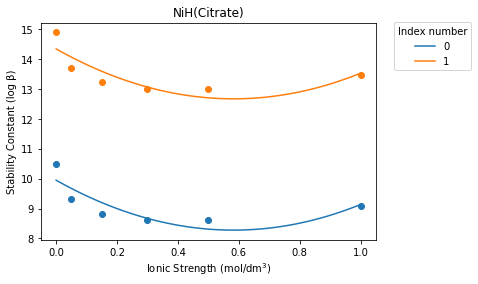

In [246]:
stability_graph_all('NiH(Citrate)')

,Species,Log_k_values,File
0,2Cu+2+2H2O=Cu2(OH)2+2+2H+,-10.3590,Amm.dat
1,Cu2S+H+=HS-+2Cu+,-34.7342,core10.dat
2,Cu2O+2H+=H2O+2Cu+,-1.9031,core10.dat
3,Cu2CO3(OH)2+3H+=HCO3-+2Cu+2+2H2O,5.9399,core10.dat
4,Cu2S+1.0000H+=+1.0000HS-+2.0000Cu+,-34.7342,llnl.dat
5,Cu2O+2.0000H+=+1.0000H2O+2.0000Cu+,-1.9031,llnl.dat
6,Cu2CO3(OH)2+3.0000H+=+1.0000HCO3-+2.0000Cu+++2...,5.9399,llnl.dat
7,2Cu+2+Glycine-=Cu2Glycine+3,15.6400,minteq.dat
8,2Cu+2+Salicylate-2=Cu2Salicylate+2,16.9400,minteq.dat
9,2Cu+2+Glutamate-2=Cu2Glutamate+2,14.8400,minteq.dat


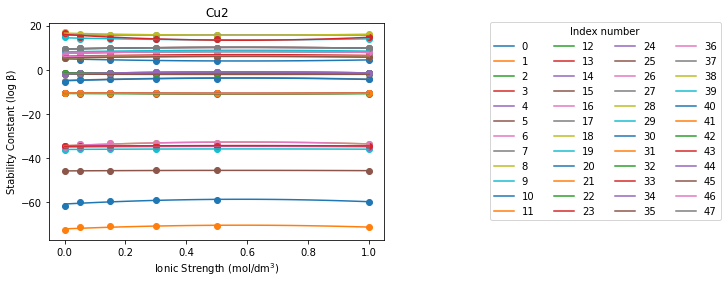

In [247]:
stability_graph_all('Cu2')